## Library Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8-pastel')

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

import optuna

In [2]:
data = pd.read_csv("UrbanEdgeApparel.csv")
data.head()

,Order ID,Order Status,Order Date,Order Day of Week,Order Month,Order Year,Customer ID,Company ID,Product ID,Product Variant ID,Product Unit Selling Price,Product Quantity,Total Selling Price,Payment Status,Shipment ID,Shipment Number,Shipping Address Type,Shipping City,Shipping State,Shipping Postal Code,Shipping Country
0,104,Completed,6/6/2013,Thursday,June,2013.0,Cust_3161,Company_87239,Prod_5030,Prod_Var_50300,4.30,50,215.00,Received,271,271,Business,Washington,District Of Columbia,20011-2343,United States
1,104,Completed,6/6/2013,Thursday,June,2013.0,Cust_3161,Company_87239,Prod_70018,Prod_Var_70018,1.50,50,75.00,Received,271,271,Business,Washington,District Of Columbia,20011-2343,United States
2,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10003,3.95,1,3.95,Received,438,438,Business,Lone Tree,Colorado,80124,United States
3,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10004,3.95,1,3.95,Received,438,438,Business,Lone Tree,Colorado,80124,United States
4,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10005,3.95,2,7.90,Received,438,438,Business,Lone Tree,Colorado,80124,United States


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89644 entries, 0 to 89643
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order ID                    89644 non-null  int64  
 1   Order Status                89644 non-null  object 
 2   Order Date                  89493 non-null  object 
 3   Order Day of Week           89493 non-null  object 
 4   Order Month                 89493 non-null  object 
 5   Order Year                  89493 non-null  float64
 6   Customer ID                 89644 non-null  object 
 7   Company ID                  86536 non-null  object 
 8   Product ID                  89644 non-null  object 
 9   Product Variant ID          86200 non-null  object 
 10  Product Unit Selling Price  89644 non-null  float64
 11  Product Quantity            89644 non-null  int64  
 12  Total Selling Price         89644 non-null  float64
 13  Payment Status              896

In [4]:
data.describe()

,Order ID,Order Year,Product Unit Selling Price,Product Quantity,Total Selling Price,Shipment ID,Shipment Number
count,89644.000000,89493.000000,89644.000000,89644.000000,89644.000000,89644.000000,89644.000000
mean,5791.785306,2018.750450,6.723333,14.024118,65.008847,8518.744857,8518.744857
std,3927.279827,3.047109,5.628675,59.990020,219.437297,5159.076899,5159.076899
min,5.000000,2013.000000,0.000000,1.000000,0.000000,50.000000,50.000000
25%,2394.000000,2016.000000,3.300000,2.000000,10.000000,4487.000000,4487.000000
50%,5176.000000,2019.000000,4.750000,3.000000,19.800000,7659.000000,7659.000000
75%,9026.000000,2021.000000,8.500000,10.000000,46.000000,12584.000000,12584.000000
max,13835.000000,2024.000000,150.000000,3600.000000,10800.000000,19425.000000,19425.000000


In [6]:
print(data.shape)
print(data.nunique())

(89644, 21)
Order ID                      11415
Order Status                      4
Order Date                     3317
Order Day of Week                 7
Order Month                      12
Order Year                       12
Customer ID                    2321
Company ID                     1036
Product ID                      302
Product Variant ID             1028
Product Unit Selling Price      227
Product Quantity                274
Total Selling Price            1981
Payment Status                    4
Shipment ID                   11415
Shipment Number               11415
Shipping Address Type             2
Shipping City                  1521
Shipping State                   86
Shipping Postal Code           2228
Shipping Country                 30
dtype: int64


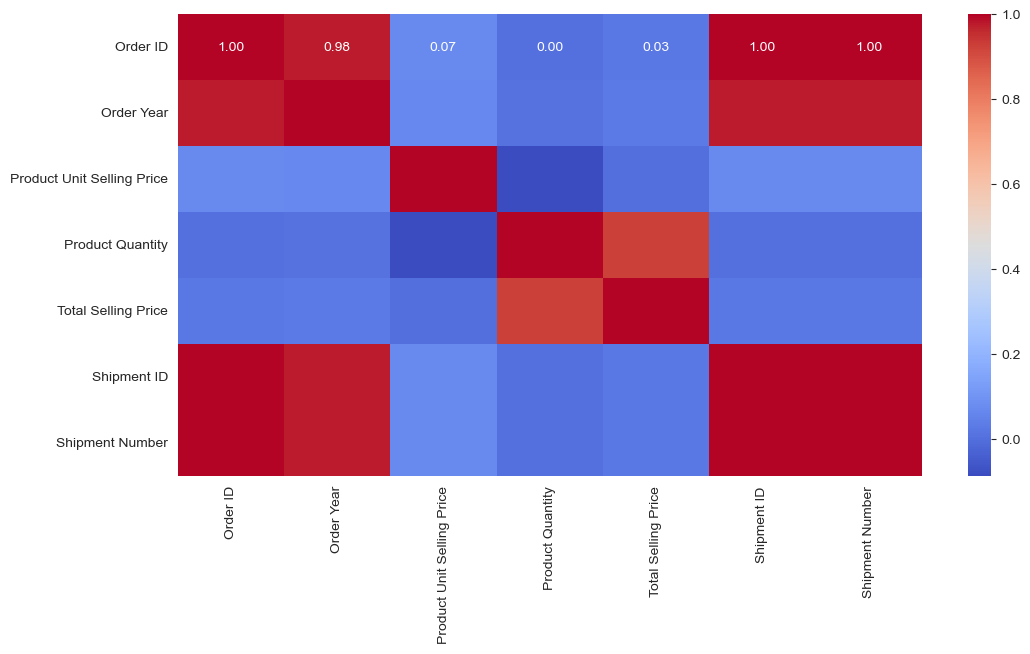

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [10]:
data.isnull().sum()

Order ID                         0
Order Status                     0
Order Date                     151
Order Day of Week              151
Order Month                    151
Order Year                     151
Customer ID                      0
Company ID                    3108
Product ID                       0
Product Variant ID            3444
Product Unit Selling Price       0
Product Quantity                 0
Total Selling Price              0
Payment Status                   0
Shipment ID                      0
Shipment Number                  0
Shipping Address Type            0
Shipping City                   37
Shipping State                  90
Shipping Postal Code            37
Shipping Country                37
dtype: int64

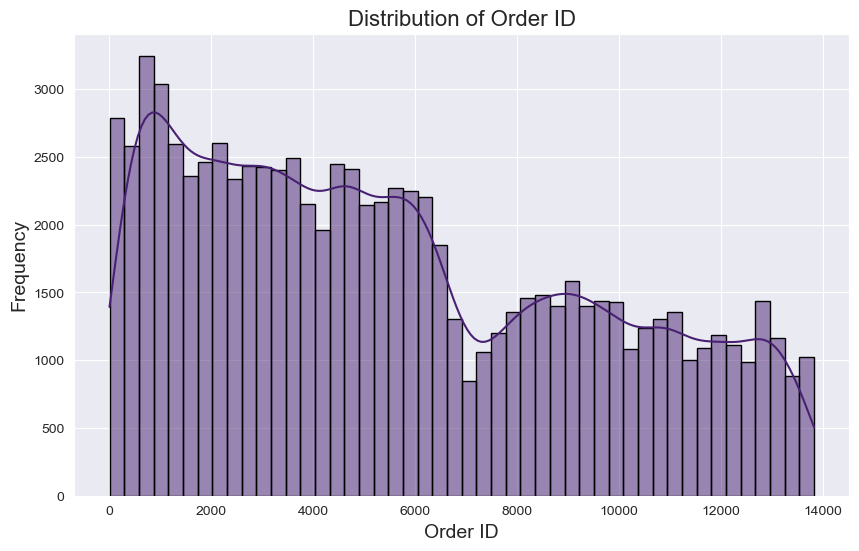

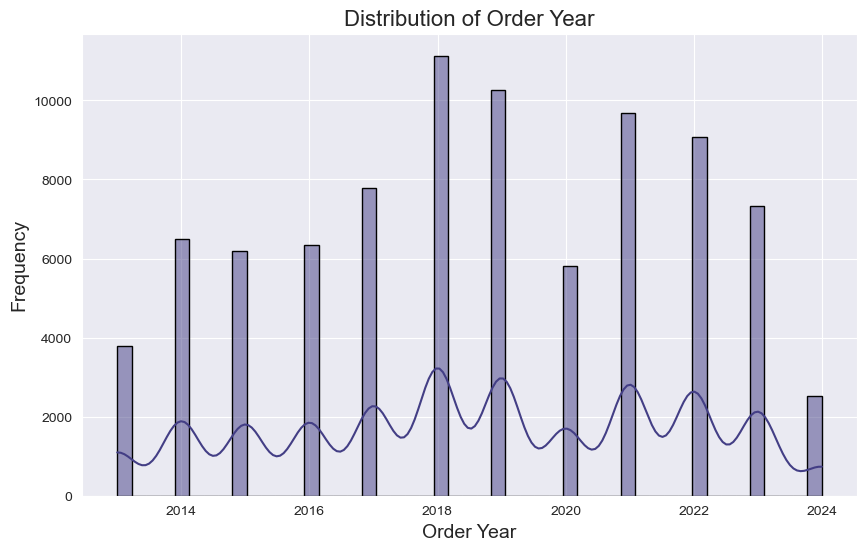

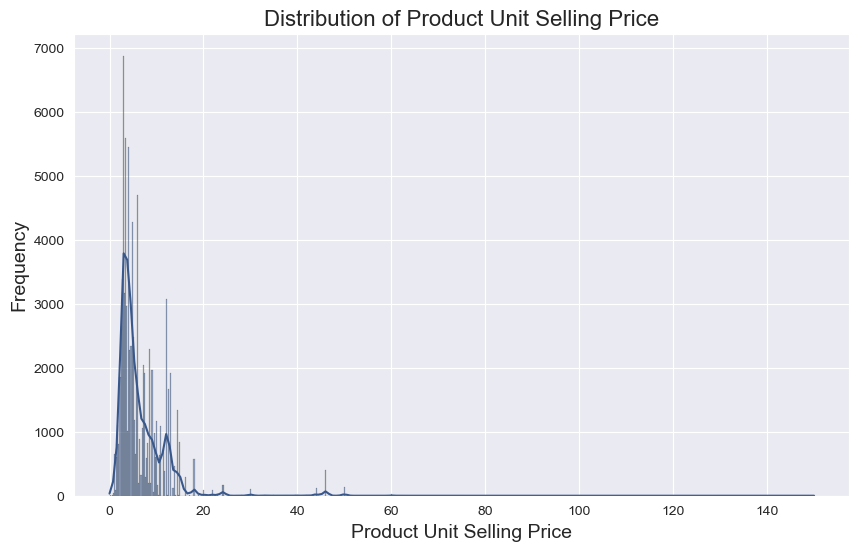

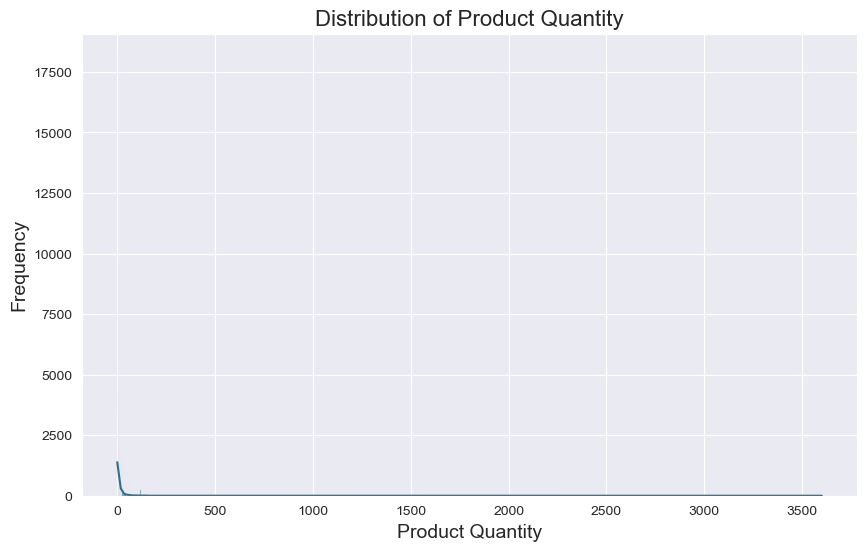

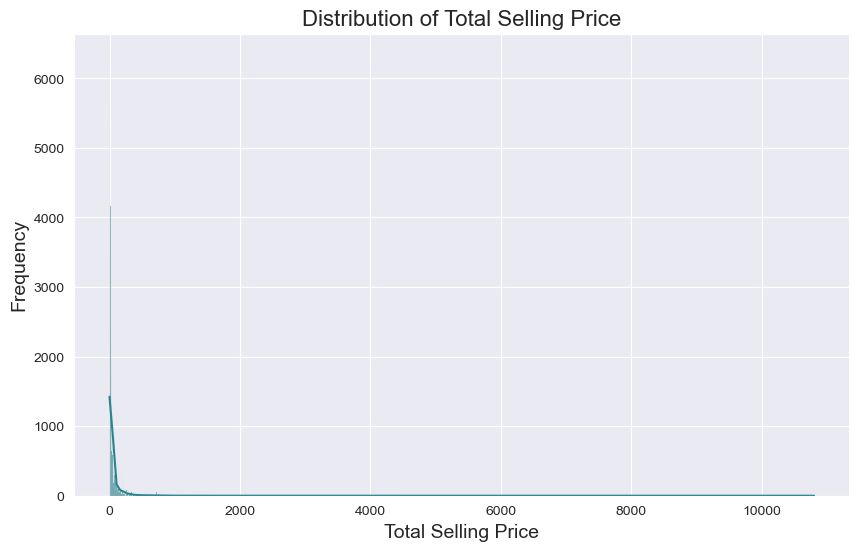

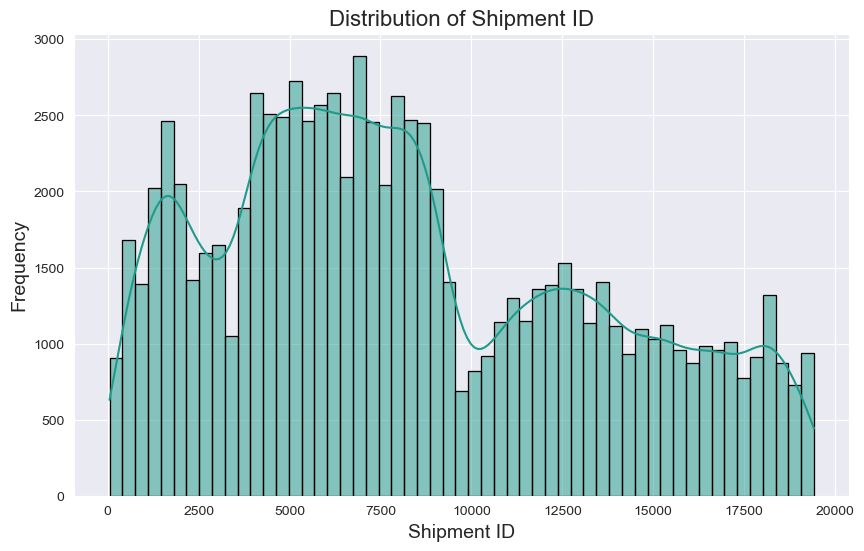

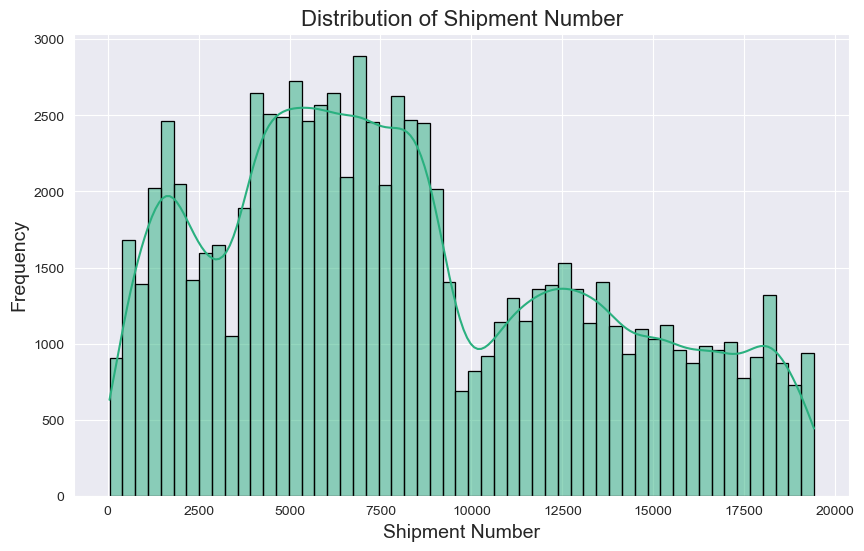

In [15]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, color=sns.color_palette("viridis", 10)[numeric_columns.get_loc(col)], edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.show()

In [13]:
# Drop rows with missing Company ID
data = data.dropna(subset=['Company ID'])

# Drop rows with missing Shipping information
data = data.dropna(subset=['Shipping City', 'Shipping State', 'Shipping Postal Code', 'Shipping Country'])

# Drop Product Variant ID column if not needed
data = data.drop(columns=['Product Variant ID'])

# Check remaining missing values
remaining_missing_values_after_drop = data.isnull().sum()

remaining_missing_values_after_drop

Order ID                       0
Order Status                   0
Order Date                    22
Order Day of Week             22
Order Month                   22
Order Year                    22
Customer ID                    0
Company ID                     0
Product ID                     0
Product Unit Selling Price     0
Product Quantity               0
Total Selling Price            0
Payment Status                 0
Shipment ID                    0
Shipment Number                0
Shipping Address Type          0
Shipping City                  0
Shipping State                 0
Shipping Postal Code           0
Shipping Country               0
dtype: int64

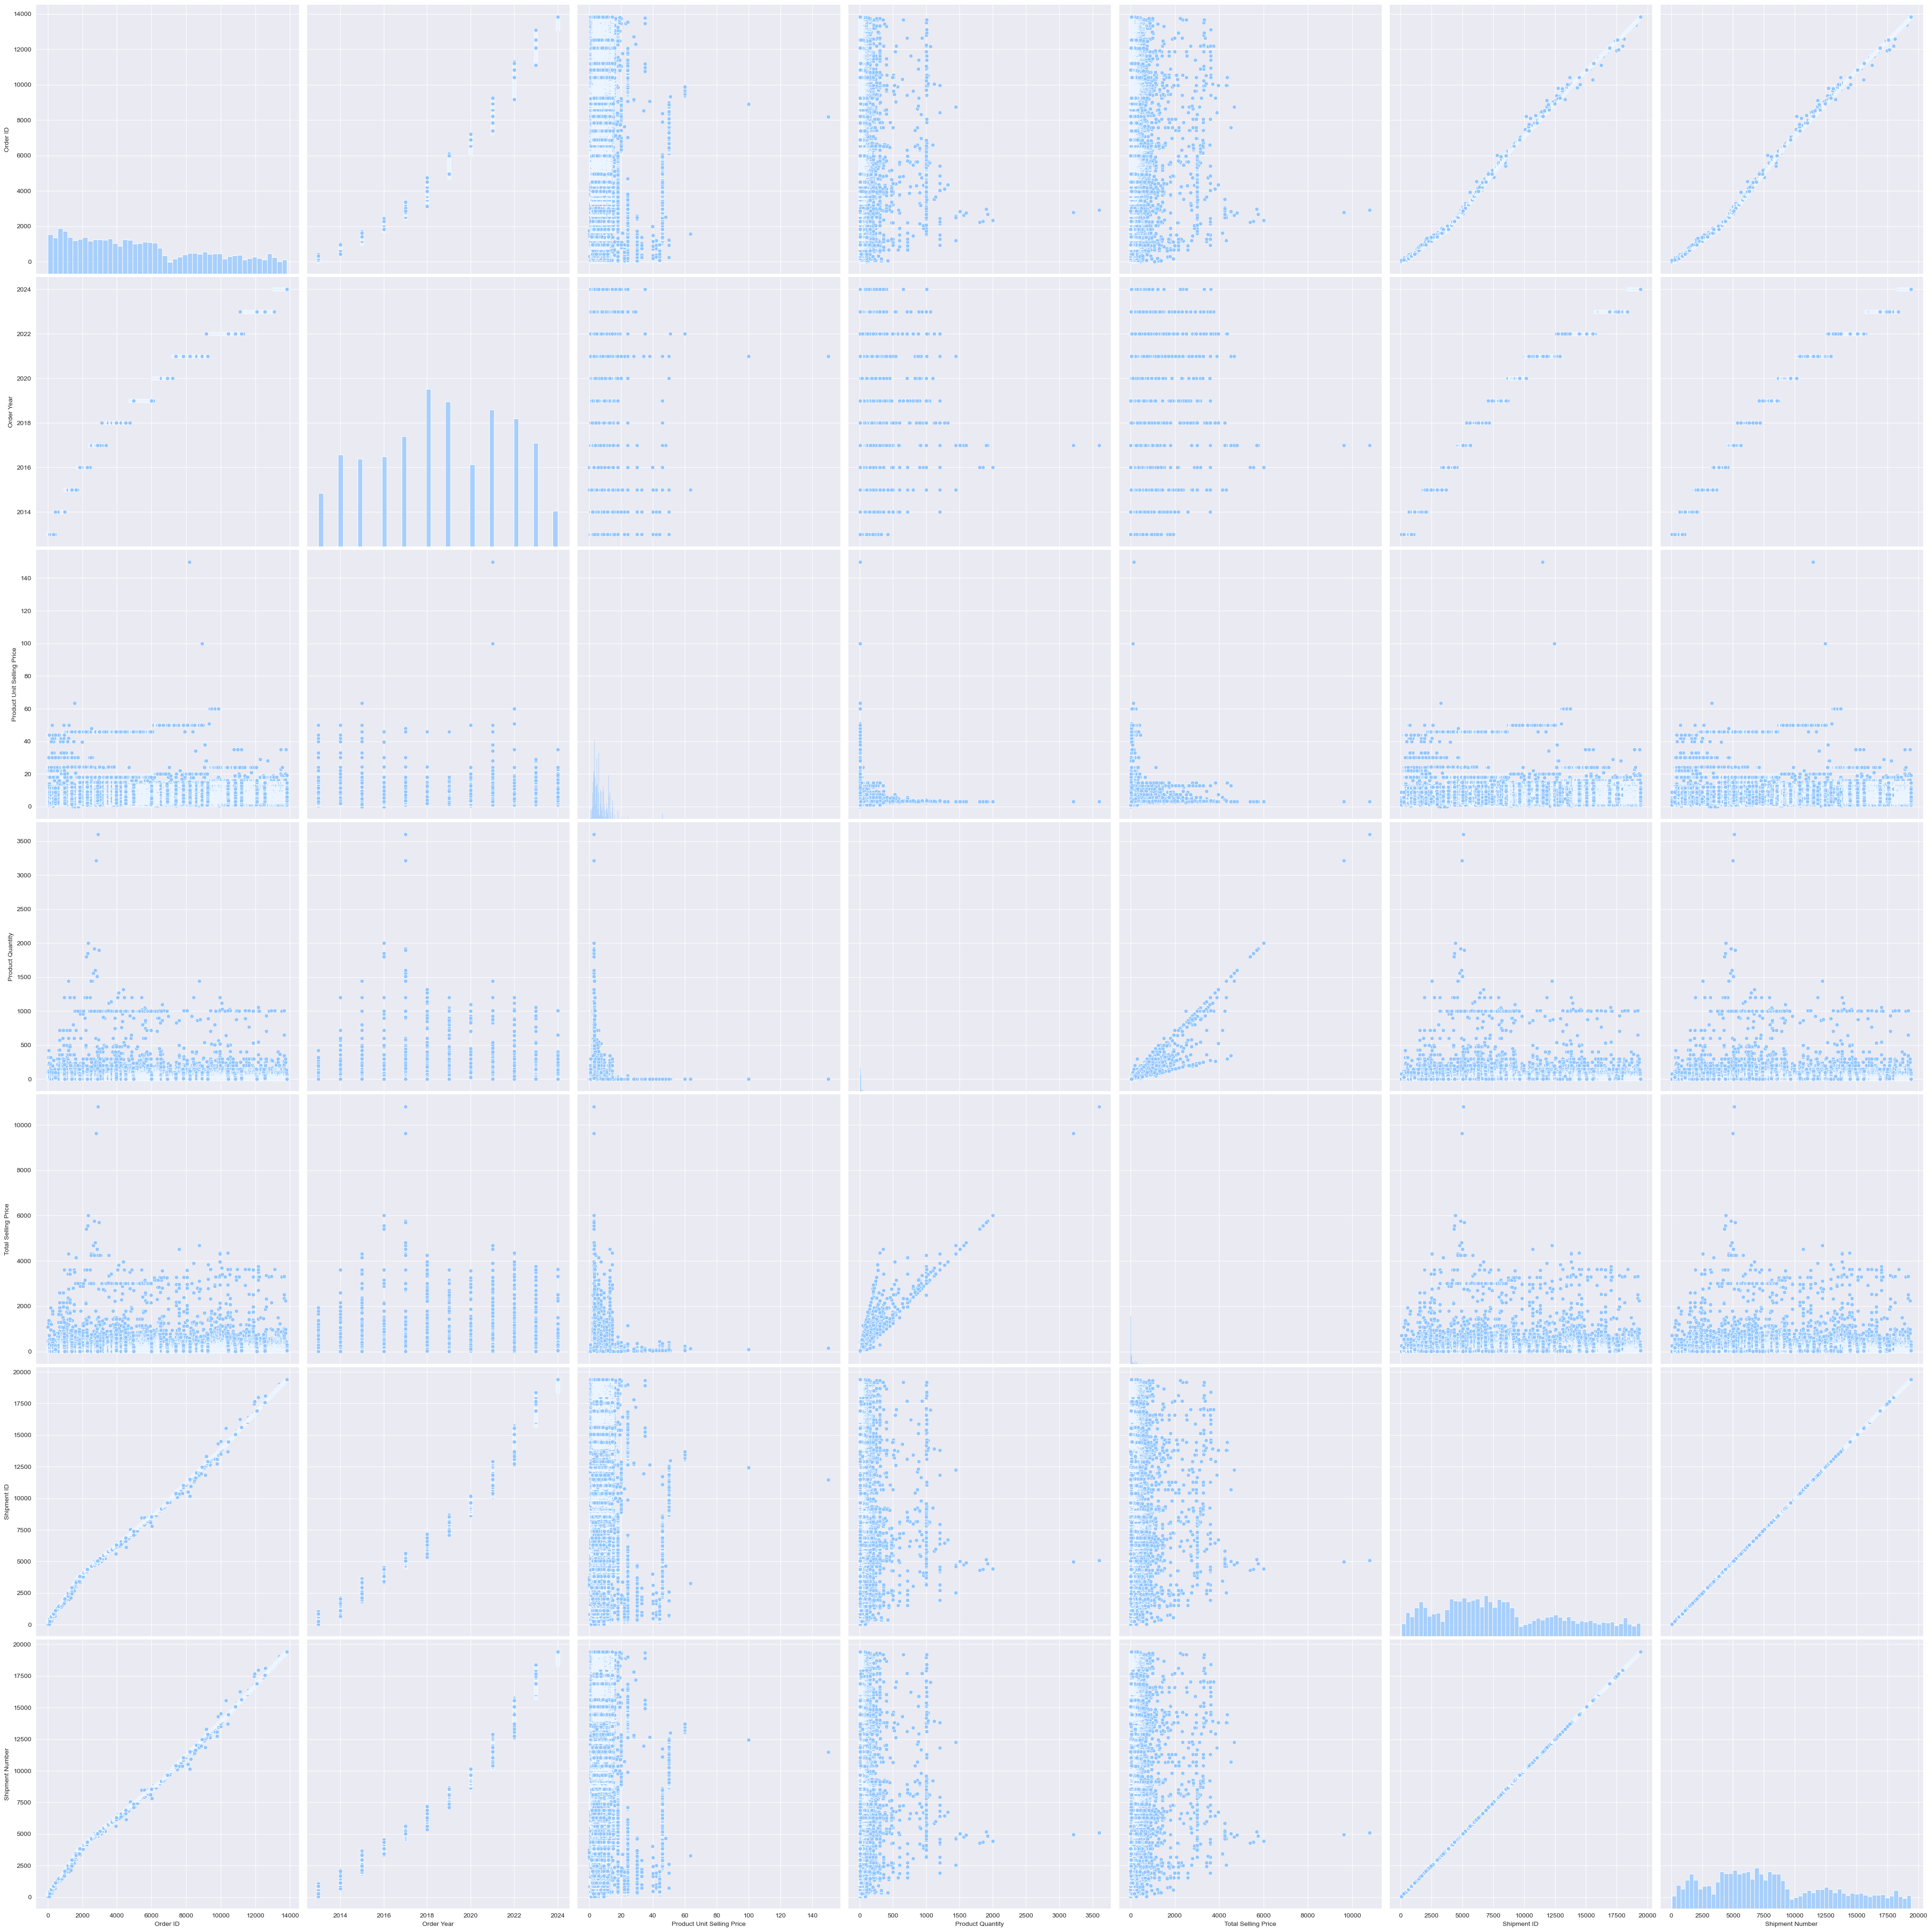

In [16]:
# Pairplot to examine relationships
sns.pairplot(data[numeric_columns], palette="tab20", size=6)
plt.show()

In [18]:
# Summarize sales by Company, Product, and Country
grouped_by_company = data.groupby('Company ID').agg({
    'Product Quantity': 'sum',
    'Total Selling Price': 'sum',
    'Product Unit Selling Price': 'sum'
}).reset_index()

grouped_by_product = data.groupby('Product ID').agg({
    'Product Quantity': 'sum',
    'Total Selling Price': 'sum',
    'Product Unit Selling Price': 'sum'
}).reset_index()

grouped_by_country = data.groupby('Shipping Country').agg({
    'Product Quantity': 'sum',
    'Total Selling Price': 'sum',
    'Product Unit Selling Price': 'sum'
}).reset_index()

# Display top 5 of each by product quantity
grouped_by_company_top5 = grouped_by_company.sort_values(by='Product Quantity', ascending=False).head()
grouped_by_product_top5 = grouped_by_product.sort_values(by='Product Quantity', ascending=False).head()
grouped_by_country_top5 = grouped_by_country.sort_values(by='Product Quantity', ascending=False).head()

grouped_by_company_top5

,Company ID,Product Quantity,Total Selling Price,Product Unit Selling Price
317,Company_43754,185414,768594.01,31009.10
118,Company_23721,181175,810852.13,28175.80
336,Company_45730,172226,844167.90,7265.95
397,Company_51717,55212,190762.70,7210.44
459,Company_57624,41257,131871.50,1616.07


In [19]:
grouped_by_country_top5

,Shipping Country,Product Quantity,Total Selling Price,Product Unit Selling Price
23,United States,1178120,5470979.79,551136.34
11,Japan,55212,190762.70,7210.44
21,"Tanzania, United Republic Of",992,3833.90,593.55
4,Côte d'Ivoire,852,6569.40,525.85
5,Dominican Republic,793,5000.25,775.60


In [20]:
grouped_by_product_top5

,Product ID,Product Quantity,Total Selling Price,Product Unit Selling Price
6,Prod_1009,217397,672189.83,9684.75
35,Prod_1140,180709,606535.61,11096.31
1,Prod_1000,71295,307087.33,22388.68
80,Prod_2024,62064,313441.75,12319.00
8,Prod_10150,54718,171598.45,2466.55
